# L'influence des promotions sur les ventes d'un supermarché 

Auteurs : Jarod Vanderlynden , Philippe Mathieu, [CRISTAL Lab](http://www.cristal.univ-lille.fr), [SMAC team](https://www.cristal.univ-lille.fr/?rubrique27&eid=17), [Lille University](http://www.univ-lille.fr), Romain Warlop, [fifty-five](https://www.fifty-five.com/fr/)

email : jarod.vanderlynden.etu@univ-lille.fr

Création : 5/12/2022


## Introduction

Cette feuille Jupyter décrit un exemple d'utilisation du modèle proposé dans l'article "_Comprendre l'impact des stratégies de prix sur le comportement des consommateurs_". 
Ce modèle permet notamment de construire un outil de simulation reproduisant des faits marketings connus et capable d'en mesurer les performances.
Ce notebook détaille ce modèle et en présente les résultats principaux.

Ce modèle représente un supermarché dans lequel on vend des biens de consommation courante. Les agents sont des abstractions des clients (une personne, une famille etc.) ayant chacun leurs propres paramètres internes (sensibilités). Les agents sont omniscients et connaissent tous les produits. Le modèle ne prend pas en compte la géographie du magasin ni l'emplacement des produits. 


In [1]:
from src.model import *

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

### Les packs

Les promotions étudiées ici s'appuient sur la notion de pack ou de lots d'une même entité. Afin couvrir toutes les situations, l'ensemble de ce qui est vendu dans le supermarché est décrit par la notion de pack. La notion de pack est à comprendre au sens large : un pack peut être constitué d'un unique produit ou d'un produit répété plusieurs fois. Par contre on ne traite pas de packs de produits différents.

Les packs sont des ensembles de biens de consommation simples, disposant de 5 caractéristiques : un prix, une qualité, une quantité, et un booléen de promotion. Ils sont identifiés par leur nom.

Ils sont instanciés via la classe `Pack(Nom,Prix,Qualité,Quantité)`. Le prix est un prix unitaire, la qualité un réel entre 0 et 1 , 0 représentant une qualité médiocre et 1 représentant la meilleure qualité possible, la quantité le nombre d'unités présentes dans le pack. La quantité de produit fait référence au nombre de produits unitaires dans le pack. Pour des raisons de simplicité, nous ne modélisons pas le volume d'un produit (en gramme, en ml, etc.). Quand un pack est initialement créé, la promotion est mise à False, c'est pourquoi elle n'est pas dans le constructeur. Le produit n'est pas modélisé en tant que tel, mais à travers un pack.


In [4]:
# un pack de 2 paquets de pâtes
p0 = Pack("Pâtes de marque X", 2.3, 0.5, 2)

# une seule bouteille de shampoing de qualité
p1 = Pack("Un shampoing de marque X", 8.0, 1.0, 1)

# un lot 4 shampoings de moyenne gamme
p2 = Pack("Lot shampoing de marque Y", 5.0, 0.5, 4)


Le pack `p0` est un pack de 2 produits, au prix unitaire de `2.3`, ce qui donne un prix global pour le pack de 4.6.

In [5]:
p0.get_price_unit(),p0.get_price_total()

(2.3, 4.6)

Pour plus de réalisme les packs sont répartis en différentes catégories. Une catégorie représente des produits comparables entre eux ("eaux" par ex). Dans ce modèle un client ne choisira qu'un seul pack de plusieurs produits dans une catégorie donnée (un pack d'eau de 6 bouteilles, dans la catégorie "eaux" par ex).

Une catégorie est instanciée avec `Category(nom,liste de packs)`. La création d'une catégorie nécessite une liste de packs. Cette liste de packs peut être initialement vide, on ajoutera alors les packs au fur et à mesure à l'aide de la méthode `add_pack(pack)`. 

In [6]:
# les pates
cat1 = Category("pates",[p0])
cat1.show_packs()

Nom :  Pâtes de marque X , Prix total :  4.6


0

In [7]:
# les shampoings
cat2 = Category("shampoing",[])
cat2.add_pack(p1)
cat2.add_pack(p2)
cat2.show_packs()

Nom :  Lot shampoing de marque Y , Prix total :  20.0
Nom :  Un shampoing de marque X , Prix total :  8.0


0

- Un pack donne accès à plusieurs méthodes dont ``get_name(),get_price_total(),simple_promotion(percent)``, percent étant le pourcentage de réduction à appliquer au produit lors d'une promotion.
- Une catégorie donne accès à plusieurs méthodes dont ``add_pack(pack), get_packs(), show_packs()``

### Le SMA

L'environnement correspond au supermarché. On ne s'interesse pas dans ce modèle au placement géographique des packs, et les agents sont omniscients. Il n'est donc pas necessaire de représenter explicitement l'environnement.
Le SMA est donc constitué uniquement des agents et de la liste des packs étudiés. Afin de l'instancier on lui fournit une liste de catégories qui elles-mêmes contiennent les packs. 
Un magasin plus complet devrait idéalement contenir plusieurs catégories contenant plusieurs packs. Dans cet exemple nous restons à une seul catégorie pour illustrer les résultats, mais le modèle est capable de traiter plusieurs catégories.
Le SMA est instancié avec `SMA(list_cat[cat1,cat2,...],nb_agent,nb_ticks)`, `list_cat` étant une liste de catégorie, `nb_agent` le nombre d'agents, et `nb_ticks` le nombre de pas de temps de simulation que nous souhaitons réaliser.

Dans ce modèle simplifié, nous partons du principe que les packs sont disponibles en quantité infinie. Il n'y a donc pas de quantité en stock ni de rupture de stock. 

Le paramètre `nb_agents` génère `n` agents dont les caractéristiques sont aléatoires (besoins, sensibilités etc ...).


In [8]:
# Création du SMA sans aucun agent
mon_sma = SMA([cat1,cat2],0,10)

In [9]:
mon_sma.initialise()

0

Il n'y a pour l'instant encore aucun agent. Si la simulation est lancée maintenant, bien évidemment rien ne se passe.
L'attribut `revenus` permet d'obtenir le chiffre d'affaire obtenu à chaque pas de temps de simulation.
Nous avons indiqué précédemment notre souhait d'avoir 10 tours de parole, si on execute le SMA, on obtient alors 10 valeurs, pour l'instant toutes à zero puisqu'il n'y a personne.

In [10]:
mon_sma.run()
mon_sma.get_turnover()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Les agents

Les agents représentent les clients. Un client possède ses propres caractéristiques (sensibilités) et réalise des choix en conséquence durant son processus d'achat. 
Il est instancié via la classe `Agent(nom, SMA, Historique, Profil)`. SMA référence le système dans lequel l'agent évolue. Historique et profil sont des paramètres optionnels (aléatoires si non précisés).

In [11]:
# Cet agent dispose d'un historique d'achats et d'un profil tirés aléatoirement. 
a1 = Agent("Mon 1er agent",mon_sma)

#### Les profils / sensibilités
Dans ce modèle, le profil d'un agent caractérise les sensibilités de celui ci: Il est constitué d'une map de 4 clés `Prix`, `Qualité`, `Inertiel` `Promophile`, associé a des valeurs de type pourcentage totalisant 100%. Certains agents accordent plus d'importance au prix, et correspondent aux clients à petit budget. A l'inverse certains agents accordent beaucoup d'importance à la qualité, et correspondent au client qui dispose d'un gros budget, achetant les produits de bonne qualité. Les promophiles sont sensibles aux promotions, les inertiels fidèles à une marque. Quand toutes ces variables sont à peu près équivalentes on parlera de profil équilibré. Dans ce cas les clients accordent une importance à peu près similaire à toutes les caractéristiques des produits. 

In [12]:
# Création d'un profil sensible aux promotions et aux prix 
profil1 = Profil({'inertia': 0.03,'price': 0.46,'quality': 0.05,'promophile': 0.46})
profil1.get_profil()

{'inertie': 0.03, 'price': 0.46, 'quality': 0.05, 'promophile': 0.46}

In [13]:
# Création d'un profil sensible a la qualité et loyal
profil2 = Profil({'price': 1,'quality': 20,'inertia': 20,'promophile': 1})
profil2.get_profil()

{'inertie': 0.47619047619047616,
 'price': 0.023809523809523808,
 'quality': 0.47619047619047616,
 'promophile': 0.023809523809523808}

Le profil peut être affecté à un agent à sa création 

In [14]:
a2 = Agent("Agent 2", mon_sma, profil=profil1)
a2.get_profil()

{'inertie': 0.03, 'price': 0.46, 'quality': 0.05, 'promophile': 0.46}

In [15]:
a3 = Agent("Agent 3", mon_sma, profil=profil2)
a3.get_profil()

{'inertie': 0.47619047619047616,
 'price': 0.023809523809523808,
 'quality': 0.47619047619047616,
 'promophile': 0.023809523809523808}

Il est aussi possible de créer directeur un agent avec un profil aléatoire. Dans ce cas, le tirage n'est pas uniforme mais met toujours en évidence l'une des 4 caratéristiques, sauf pour le profil équilibré.

In [21]:
# initialisation d'un profil aléatoire
a4 = Agent("Agent 4",mon_sma)
a4.get_profil()

{'inertie': array([0.05832153]),
 'price': array([0.06583881]),
 'quality': array([0.784454]),
 'promophile': array([0.09138567])}

### L'historique

L'historique représente les derniers achats d'un agent par catégorie. Cet historique est une map avec pour clés les différentes catégories possibles et en valeurs la liste des packs de cette catégorie achetés par cet agent dans le passé et en quelle quantité. Par défaut, l'historique est une fenêtre glissante de taille 50 par catégorie.

Pour réaliser une expérience, l'agent doit impérativement avoir un historique d'achats. Soit on laisse le SMA l'initialiser aléatoirement à la création de l'agent, soit affecte à l'agent un historique spécifique avec la méthode `History (dict{catégorie1:achats,...},dict{catégorie1:quantité,....})`. 

In [ ]:
# L'historique généré aléatoirement de l'agent précédent. 
a1.get_history()

{'pates': [(Pâtes de marque X, 5),
  (Pâtes de marque X, 11),
  (Pâtes de marque X, 8),
  (Pâtes de marque X, 10),
  (Pâtes de marque X, 4),
  (Pâtes de marque X, 10),
  (Pâtes de marque X, 10),
  (Pâtes de marque X, 9),
  (Pâtes de marque X, 12),
  (Pâtes de marque X, 0),
  (Pâtes de marque X, 9),
  (Pâtes de marque X, 9),
  (Pâtes de marque X, 5),
  (Pâtes de marque X, 1),
  (Pâtes de marque X, 1),
  (Pâtes de marque X, 1),
  (Pâtes de marque X, 0),
  (Pâtes de marque X, 6),
  (Pâtes de marque X, 0),
  (Pâtes de marque X, 6),
  (Pâtes de marque X, 7),
  (Pâtes de marque X, 12),
  (Pâtes de marque X, 6),
  (Pâtes de marque X, 5),
  (Pâtes de marque X, 6),
  (Pâtes de marque X, 1),
  (Pâtes de marque X, 0),
  (Pâtes de marque X, 9),
  (Pâtes de marque X, 8),
  (Pâtes de marque X, 1),
  (Pâtes de marque X, 11),
  (Pâtes de marque X, 6),
  (Pâtes de marque X, 10),
  (Pâtes de marque X, 5),
  (Pâtes de marque X, 7),
  (Pâtes de marque X, 12),
  (Pâtes de marque X, 0),
  (Pâtes de marque X

In [18]:
a5 = Agent("Agent 5",mon_sma,history = H)

Ajoutons ces 3 agents à notre environnement. Attention a bien passer une liste en paramètre.

In [19]:
mon_sma.add_agent([a2,a3,a4,a5])

## La simulation

La simulation peut être lancée plusieurs fois, un résultat différent devrait apparaître. Cela est dû à l'aspect aléatoire du modèle notamment dans le processus d'achats des agents, l'agent choisi un produit d'une catégorie selon une loi de probabilité proportionnelle au score du produit. 

In [20]:
mon_sma.initialise()
mon_sma.run()
mon_sma.get_turnover()

array([ 41.4,  59.8,  46. ,  69. ,  73.6,   0. , 119.6,  27.6,  46. ,
        92. ])

On peut alors afficher l'évolution du chiffre d'affaires à chaque pas de temps. Celui ci correspond à :

$\forall a:Agents \Sigma(packs achetés * quantités achetées * prix)$

Il est aussi possible d'afficher à chaque pas de temps ce que les agents ont acheté.

In [21]:
mon_sma.initialise()
mon_sma.run(trace=True)
mon_sma.get_turnover()

Pas de temps num :  0  Agent :  Agent 2  Besoin 7.85  Achat : Rien Quantité : 0
Pas de temps num :  0  Agent :  Agent 3  Besoin 5.85  Achat : Rien Quantité : 0
Pas de temps num :  0  Agent :  Agent 4  Besoin 2.15  Achat :  Pâtes de marque X Quantité :  1
Pas de temps num :  0  Agent :  Agent 5  Besoin 8.2  Achat : Rien Quantité : 0
Pas de temps num :  1  Agent :  Agent 2  Besoin 7.75  Achat : Rien Quantité : 0
Pas de temps num :  1  Agent :  Agent 3  Besoin 6.95  Achat :  Pâtes de marque X Quantité :  15
Pas de temps num :  1  Agent :  Agent 4  Besoin 2.0  Achat : Rien Quantité : 0
Pas de temps num :  1  Agent :  Agent 5  Besoin 8.9  Achat :  Pâtes de marque X Quantité :  12
Pas de temps num :  2  Agent :  Agent 2  Besoin 7.55  Achat :  Pâtes de marque X Quantité :  2
Pas de temps num :  2  Agent :  Agent 3  Besoin 6.7  Achat : Rien Quantité : 0
Pas de temps num :  2  Agent :  Agent 4  Besoin 1.85  Achat : Rien Quantité : 0
Pas de temps num :  2  Agent :  Agent 5  Besoin 8.5  Achat : R

array([  4.6, 124.2,   9.2,  73.6,  96.6,   4.6, 119.6,  13.8,  64.4,
        82.8])

## Une experience volumineuse

Nous allons générer un environnement plus dense (avec plus d'agents et de produits). Nous resterons sur des simulations avec une seule catégorie de produit car les catégories de produits ne s'influencent pas entre-elles.

Créons d'abord une catégorie de produit contenant 9 produits. Nous avons choisi de faire 9 produits assez similaire notamment sur le ratio qualité/prix pour éviter l'apparition d'un "super produit", de meilleur qualité et moins cher que les autres, que tous les agents achèteraient. Il est tout à fait possible de créer cette catégorie à la main ou de tout autre manière.

In [22]:
base_price = np.random.randint(10, 100)
packs = []
for j in range(3):
    price = base_price + np.random.normal(0,(base_price/4))   # On tire un prix de base aléatoire
    quality = np.random.normal((price/100),0.1)               # On tire une qualité proportionnelle au prix
    for i in range(3):                                        # Création de 3 produits qu'on considérera d'une même marque (même qualité)
        packs.append(Pack(("Produit " + str(i+(j*3))), price, np.absolute(quality), 2 * (i+1)))
        price = price * 0.9                                   # On estime que le prix à l'unité est plus bas sur les produits vendu en grand quantité
Ma_categorie = Category("Ma_categorie", packs)

Création de l'environnement

In [23]:
sma_de_test = SMA([Ma_categorie],300,100)

In [24]:
sma_de_test.initialise()

0

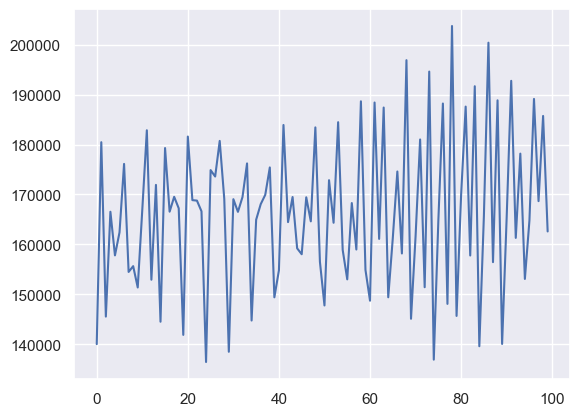

In [25]:
sma_de_test.run()
plt.plot(sma_de_test.get_turnover())

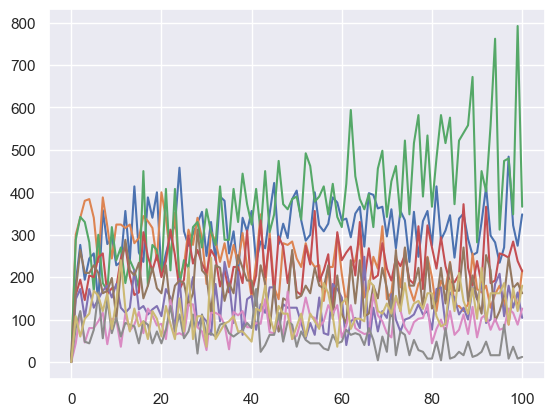

0

In [26]:
sma_de_test.show_sales()

In [ ]:
sma_de_test.show_sales_separated()

In [ ]:
sma_de_test.show_sales_separated()

## La promotion
L'environnement dispose de toutes les informations nécéssaires, nous allons pouvoir appliquer différentes promotions à notre modèle via la méthode `make_promo(type,quantity,ticks,category,pack)`.

`type` est le type de promotion. (0 de type pourcentage de réduction, 1 de type x acheté y offert)

`quantity` le pourentage de la promotion (si c'est une promotion en %) ou un tuple (x,y) si c'est une promotion x acheté y offert.

`ticks` un tuple contenant le pas de temps du début de la prodmotion et le pas de temps de fin de promotion. 

`category` l'indice de a categorie sur laquel faire la promotion.

`pack` l'indice du produit sur lequel faire la promotion. 

Par exemple `make_promo(0,40,(30,34),0,0)` : 0 pour une promotion en pourcentage, 40 pour 40% (30 pas de temps de départ, 34, pas de temps d'arrêt) et 0,0 pour la catégorie d'indice 0 et le produit d'indice 0

In [ ]:
sma_de_test.initialise()
sma_de_test.make_promo((0,40,(30,34),0,0))
sma_de_test.run()

In [ ]:
plt.plot(sma_de_test.revenues)

In [ ]:
sma_de_test.show_sales()

In [ ]:
sma_de_test.show_sales_separated()

On observe sur cette simulation que le produit 0, qui est le produit en promotion, voit une forte augmentation de ses ventes durant la promotion. 
Afin de pouvoir observer l'impact des promotions plus préciséments nous allons comparer une même simulation avec et sans promotion. 

Afin d'avoir les mêmes agents dans chaque simulation pour la comparaison nous proposons de fixer la graine aléatoire. 

In [ ]:
np.random.seed(3)
base_price = np.random.randint(10, 100)
packs = []
#Création des produits selon la même méthode que précédemment.
for j in range(3):
    price = base_price + np.random.normal(0,(base_price/4))   
    quality = np.random.normal((price/100),0.1)               
    for i in range(3):                                      
        packs.append(Pack(("Produit " + str(i+(j*3))), price, np.absolute(quality), 2 * (i+1)))
        price = price * 0.9  
Ma_categorie = Category("Ma_categorie", packs)

In [ ]:
np.random.seed(3)
sma_avec_promo = SMA([Ma_categorie],300,100)
np.random.seed(3)
sma_sans_promo = SMA([Ma_categorie],300,100)

In [ ]:
sma_avec_promo.initialise()
sma_avec_promo.make_promo((0,40,(30,34),0,0))
sma_sans_promo.initialise()

In [ ]:
sma_avec_promo.run()
sma_sans_promo.run()

Si on veut, il est possible d'afficher les résultats sur une même figure de cette manière :

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(sma_sans_promo.get_sales())
axs[1].plot(sma_avec_promo.get_sales())

On peut observer le pic des ventes du produit 0 (en bleu) au moment de la promotion ainsi qu'une certaine fidélisation. 

## Un test plus simple pour la guerre des prix

On génère 2 produits assez similaires, un porté sur la qualité, l'autre sur le prix. On peut aussi imaginer deux produits très différents en terme de prix/qualité ou encore 2 produits encore plus similaires. Ces caratéristiques auront un impact sur les courbes que nous allons observer. Le but ici est de présenter une guerre des prix, avec des baisses successives du prix des produits. 

Dans un premier temps la méthode SMA.get_favorites() permet de récupérer pour chaque produit le nombre d'agent ayant pour favorit le produit. Un agent a pour produit favori celui qu'il le plus acheté dans l'historique de l'agent. Voici comment utiliser get_favorites():

In [ ]:
#On fait la simulation
cat_0 = Category("catégorie 0",[Pack("Produit_A", 10, 0.5, 1), Pack("Produit_B", 12, 0.7, 1)])
sma_avec_guerre_des_prix = SMA([cat_0],300,10)
sma_avec_guerre_des_prix.initialise()
sma_avec_guerre_des_prix.run()
#On récupère les informations
results = sma_avec_guerre_des_prix.get_favorites()
results

In [ ]:
plt.plot(results['Produit_A'],label='Produit_A')
plt.plot(results['Produit_B'],label='Produit_B')
plt.legend()

On observe que le produit B est légèrement meilleur que le produit A sur notre population d'agents. 

On relance une simulation avec des produits différents pour illustrer le fait qu'avec seulement 2 produits en concurence direct leurs paramètres ont une grand importance. 

De plus la prise en compte des paramètres globaux peuvent faire varier l'importance du prix ou de la qualité. 

In [ ]:
cat_0 = Category("catégorie 0",[Pack("Produit_A", 6, 0.6, 1), Pack("Produit_B", 24, 0.7, 1)])
sma_avec_guerre_des_prix = SMA([cat_0],300,10)
sma_avec_guerre_des_prix.initialise()
sma_avec_guerre_des_prix.run()
#On récupère les informations
results = sma_avec_guerre_des_prix.get_favorites()
results
for k in results.keys():
    plt.plot(results[k],label=k)
plt.legend()

Nous allons réaliser des simulations de 100 pas de temps à graine aléatoire fixé (pour la comparaison)

Maintenant nous allons réaliser une simulation un peu plus longue sans changement de prix.

In [ ]:
np.random.seed(42)
#On fait la simulation
cat_0 = Category("catégorie 0",[Pack("Produit_A", 100, 0.5, 1), Pack("Produit_B", 120, 0.6, 1)])
sma_avec_guerre_des_prix = SMA([cat_0],300,100)
sma_avec_guerre_des_prix.initialise()
sma_avec_guerre_des_prix.run()
#On récupère les informations
chiffreAffaires = sma_avec_guerre_des_prix.revenues
favoris = sma_avec_guerre_des_prix.get_favorites()

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(chiffreAffaires)
for k in favoris.keys():
    axs[1].plot(favoris[k],label=k)
axs[1].legend()

Nouvelle simulation avec une baisse du prix uniquement du produit A

Un changement de prix définitif, qui n'est pas une promotion, s'effectue avec la méthode `reduce_price(pourcentage, tick d'effet, produit)` ou `raise_price(pourcentage, tick d'effet, produit)`. ce qui donne par exemple `reduce_price(20, 30, 0, 0)`.

In [ ]:
np.random.seed(42)
#On fait la simulation
cat_0 = Category("catégorie 0",[Pack("Produit_A", 100, 0.5, 1), Pack("Produit_B", 120, 0.6, 1)])
sma_avec_guerre_des_prix = SMA([cat_0],300,100)
sma_avec_guerre_des_prix.initialise()
#On indique à quel moment à lieu la baisse de prix ()
sma_avec_guerre_des_prix.reduce_price(40, 30, 0, 0)
sma_avec_guerre_des_prix.run()
#On récupère les informations
chiffreAffaires = sma_avec_guerre_des_prix.revenues
favoris = sma_avec_guerre_des_prix.get_favorites()

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(chiffreAffaires)
for k in favoris.keys():
    axs[1].plot(favoris[k],label=k)
axs[1].legend()

Finalement on réalise une simulation avec ce qu'on entend par guerre des prix, c'est à dire, le prix du produit B baisse ce qui entraine une baisse du prix du produit A ce qui entraine une baisse du produit B etc. 

In [ ]:
np.random.seed(42)
#On fait la simulation
cat_0 = Category("catégorie 0",[Pack("Produit_A", 100, 0.5, 1), Pack("Produit_B", 120, 0.6, 1)])
sma_avec_guerre_des_prix = SMA([cat_0],300,100)
sma_avec_guerre_des_prix.initialise()
#On indique à quel moment à lieu la baisse de prix ()
sma_avec_guerre_des_prix.reduce_price(20, 10, 0, 0)
sma_avec_guerre_des_prix.reduce_price(20, 20, 0, 1)
sma_avec_guerre_des_prix.reduce_price(20, 30, 0, 0)
sma_avec_guerre_des_prix.reduce_price(20, 40, 0, 1)
# envrionnement_price_war.reduce_price(20, 50, 0, 1)
# envrionnement_price_war.reduce_price(20, 60, 0, 1)
sma_avec_guerre_des_prix.run()
#On récupère les informations
chiffreAffaires = sma_avec_guerre_des_prix.revenues
favoris = sma_avec_guerre_des_prix.get_favorites()

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(chiffreAffaires)
for k in favoris.keys():
    axs[1].plot(favoris[k],label=k)
axs[1].legend()

## Les paramètres du modèle
Le modèle dispose de 7 paramètres : prix, qualité, promophile, sat_alpha, phi, c, inertie. 
Prix qualité promophile et inertie sont des paramètres que gèrent l'importance global pour les agents du prix de la qualité de la promotion et de l'inertie.

Un prix à 1 avec les autres valeurs à 0 signifierais que les agents prennent tous uniquement en compte le prix des produits pour déterminer leurs achats.

sat_alpha correspond au paramètre de régulation de la pente de la fonction de saturation (utilisé dans le calcul de la quantité). Plus il est élevé plus la pente est douce et inverssement. C est la borne supérieur de cette fonction de saturation.

Finalement Phi correspond a l'intensité de l'aversion à a perte. Phi = 0.5 équivaut à ce que perdre 1€ impact négativement un agent 1.5 fois plus que de gagner 1€ l'impact positivement. Phi = 2 correspondrait a ce même ratio égal à 3.

Jusqu'a maintenant les paramètres étaient initialisé a ces valeurs : price=0.5, quality=100, promophile=5, sat_alpha=100, phi=0.3, c = 2, inertia = 2 choisies arbitrairement. 

Les 4 paramètres globaux prix qualité promotion et inertie sont multipliés par les valeurs des produits lors des évaluations. Ainsi ces paramètres globaux régulent l'importance de chaque effet.

Par exemple le prix étant dans nos exemples ci-dessus était environ égal à 100, la qualité comprise en entre 0 et 1 la promotion égal soit à 0 soit 1 et l'inertie ayant une valeur compris entre -4 et 20. 

Ces valeurs multipliées par nos paramètres globaux on obtiens (50, [0,100], (0 ou 5), [-8,40]). Ce sont des valeurs plus proches les unes des autres, nos paramètres globaux viennent donc bien équilibrer l'impact du prix de la qualité de la promotion et de l'inertie. Il permettent aussi de jouer sur le comportement de tous les agents afin d'exacerber certains comportements.

#### C et alpha_sat
Pour mieux comprendre les valeurs alpha_sat et c on affiche la fonction de saturation en faisant varier ces valeurs.

In [ ]:
def sat(U,alpha,c):
        x = (U)
        y = math.log(c-1)
        return c / (1 + math.exp(-x/alpha+y))

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
for alpha in [1,2,5,10,20,50,100]:
    c=2
    res = np.array(np.zeros(len(np.arange(-100,100,0.01))))
    cpt = 0
    for i in np.arange(-100,100,0.01):
        res[cpt] = sat(i,alpha,c)
        cpt+=1
    axs[0].plot(np.arange(-100,100,0.01),res)
axs[0].legend(("xalpha=1","alpha=2","alpha=5","alpha=10","alpha=20","alpha=50","alpha=100") )
axs[0].set_xlabel("Valeur de U(p_i)")
axs[0].set_ylabel("Multiplicateur de quantité")
for c in [2,3,4,8,10]:
    alpha = 5
    res = np.array(np.zeros(len(np.arange(-100,100,0.01))))
    cpt = 0
    for i in np.arange(-100,100,0.01):
        res[cpt] = sat(i,alpha,c)
        cpt+=1
    axs[1].plot(np.arange(-100,100,0.01),res)
axs[1].legend(("xalpha=1","alpha=2","alpha=5","alpha=10","alpha=20","alpha=50","alpha=100") )
axs[1].set_xlabel("Valeur de U(p_i)")
axs[1].set_ylabel("Multiplicateur de quantité")

#### Simulations pour différents paramètres

Voici quelque exemples de changements de paramètres. On reprend la catégorie de produit à 8 produits utilisée précedemment. 

In [ ]:
environnement_test = SMA([Ma_categorie],300,100)

Les paramètres de l'evironnement sont passés via la méthode initialise() 
Les paramètres sont price, quality, promophile, sat_alpha, phi, c, inertia

In [ ]:
sma_de_test.initialise(inertia = 10)
sma_de_test.make_promo((0,40,(30,34),0,0))
sma_de_test.run()
sma_de_test.show_sales()

In [ ]:
sma_de_test.initialise(inertia = 0)
sma_de_test.make_promo((0,40,(30,34),0,0))
sma_de_test.run()
sma_de_test.show_sales()

In [ ]:
sma_de_test.show_sales_separated()

On vois qu'il n'y a plus de fidélisation

In [ ]:
sma_de_test.initialise(price=0.5, quality=100, promophile=5, sat_alpha=1, phi=0.3, c = 2, inertia = 2)
sma_de_test.make_promo((0,40,(30,34),0,0))
sma_de_test.run()
sma_de_test.show_sales()

In [ ]:
sma_de_test.initialise(price=2, quality=0, promophile=5, sat_alpha=100, phi=0.3, c = 2, inertia = 0)
sma_de_test.make_promo((0,40,(30,34),0,0))
sma_de_test.run()
sma_de_test.show_sales()

In [ ]:
sma_de_test.show_sales_separated()

La qualité n'ayant plus d'impact on observe que certains produits (les plus cher) ne sont plus du tout achetés 